<h1 style="text-align:center"> INFO 323: Cloud Computing and Big Data</h1>
<h2 style="text-align:center"> College of Computing and Informatics</h2>
<h2 style="text-align:center">Drexel University</h2>

<h3 style="text-align:center"> Exploratory Data Analysis using BigQuery on Flights Data</h3>
<h3 style="text-align:center"> Yuan An, PhD</h3>
<h3 style="text-align:center">Associate Professor</h3>

Reference: Data Science on the Google Cloud Platform. Valliappa Lakshmanan. O'Reilly, 2ed, April 2022

Ch5. Interactive Data Exploration

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from google.cloud import bigquery

In [2]:
bq = bigquery.Client()

## Data Ingest:
### Go to the Storage section of the GCP web console and create a new bucket
### Open CloudShell and git clone this repo: `git clone https://github.com/GoogleCloudPlatform/data-science-on-gcp`
### Then, run:
- `cd data-science-on-gcp/02_ingest`
- `./ingest_from_crsbucket bucketname`
- `./bqload.sh (csv-bucket-name) YEAR`
- `cd ../03_sqlstudio`
- `./create_views.sh`
- `cd ../04_streaming`
- `./ingest_from_crsbucket.sh`

After the above steps, 26 JSON files should appear in the folder "flights/tzcorr/' in the bucket. A table  `flights_tzcorr`  should appear in BigQuery under the dataset `dsongcp`. Use these data to conduct the exploratory data analsysis.

## Vertex AI Workbench 
GCP Vertex AI workbench provides a hosted version of JupyterLab on Google Cloud; it knows how to authenticate against Google Cloud so as to provide easy access to Cloud Storage, BigQuery, Cloud Dataflow, Vertex AI Training, and so on. 

## Jupyter magics 
Jupyter magics provide a mechanism to run a wide variety of languages and ways to add some more. The BigQuery Python package has added a few magics to make the interaction with Google Cloud Platform convenient.

For example, you can run a query on your BigQuery table using the `%%bigquery` magic environment that comes with Vertex AI Workbench:

```
%%bigquery
SELECT
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr
```

### We can save the results from BigQuery in a Pandas DataFrame for subsequent processing

In [4]:
%%bigquery df
SELECT
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
df

,frac_delayed
0,0.186111


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   frac_delayed  1 non-null      float64
dtypes: float64(1)
memory usage: 136.0 bytes


In [7]:
sql_string = """
SELECT
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr
"""

## BigQuery from Python
If there is a piece of code that you’d ultimately want to run outside a notebook (perhaps as part of a scheduled script), it’s better to use the underlying Python and not the magic pragma:15

```
sql = """
SELECT
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr
"""
from google.cloud import bigquery
bq = bigquery.Client()
df = bq.query(sql).to_dataframe()
print(df)
```

In [3]:
from google.cloud import bigquery

In [4]:
bq = bigquery.Client()

In [8]:
sql_string = """
SELECT
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr
"""

In [9]:
df = bq.query(sql_string).to_dataframe()

In [10]:
df

,frac_delayed
0,0.186111


## Exploring Arrival Delays
Now that we have a notebook up and running, let’s use it to do exploratory analysis of arrival delays because this is the variable we want to be able to predict.

## Basic Statistics

### Extract the column/attribute names from the flights data in the BigQuery databse.

In [11]:
%%bigquery flights
select * 
from dsongcp.flights_tzcorr
limit 2


Query is running:   0%|          |

Downloading:   0%|          |

In [12]:
flights.columns

Index(['ARR_AIRPORT_TZOFFSET', 'ARR_AIRPORT_LON', 'DIVERTED',
       'ARR_AIRPORT_LAT', 'DEP_AIRPORT_TZOFFSET', 'DEP_DELAY',
       'DEP_AIRPORT_LON', 'DISTANCE', 'CANCELLED', 'CRS_DEP_TIME', 'ARR_DELAY',
       'TAXI_IN', 'WHEELS_ON', 'TAXI_OUT', 'ORIGIN_AIRPORT_SEQ_ID',
       'DEP_AIRPORT_LAT', 'DEST_AIRPORT_SEQ_ID', 'DEP_TIME', 'CRS_ARR_TIME',
       'ORIGIN', 'DEST', 'UNIQUE_CARRIER', 'ARR_TIME', 'WHEELS_OFF',
       'FL_DATE'],
      dtype='object')

### How many records in the BigQuery database?

In [13]:
%%bigquery
select count(*)
from dsongcp.flights_tzcorr

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,11638158


### What is the average arr_delay for each dep_delay?

In [14]:
%%bigquery df
select dep_delay, avg(arr_delay) as avg_arr_delay
from dsongcp.flights_tzcorr
group by dep_delay

Query is running:   0%|          |

Downloading:   0%|          |

In [15]:
df.sort_values('dep_delay')

,dep_delay,avg_arr_delay
790,-82.0,-80.0
179,-68.0,-87.0
367,-61.0,-77.0
628,-56.0,-26.0
685,-55.0,-60.0
...,...,...
714,1649.0,1636.0
1175,1670.0,1665.0
744,1878.0,1898.0
1057,1988.0,1971.0


### Let's visualize the avg_arr_delay vs. dep_delay for dep_delay < 60 mins

In [16]:
df = df[df.avg_arr_delay < 60]

Text(0, 0.5, 'avg_arr_delay')

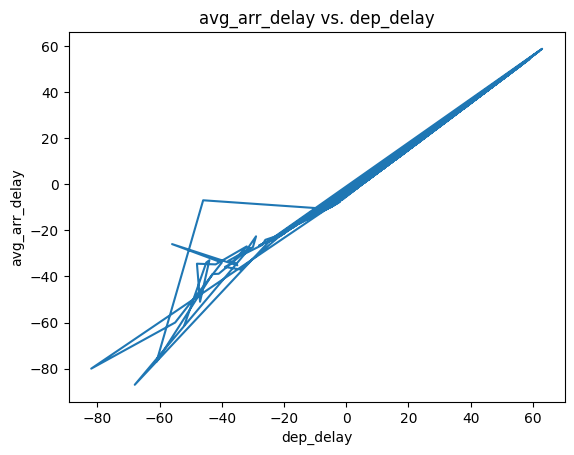

In [17]:
plt.plot(df.dep_delay, df.avg_arr_delay)
plt.title("avg_arr_delay vs. dep_delay")
plt.xlabel("dep_delay")
plt.ylabel("avg_arr_delay")

### Are the records of dep_delay < -20 mins outliers?

In [15]:
df[df.dep_delay < -20]

,dep_delay,avg_arr_delay
67,-21.0,-22.299781
80,-28.0,-26.595745
92,-26.0,-24.145349
123,-27.0,-26.380952
134,-33.0,-30.440000
172,-29.0,-22.636364
173,-30.0,-27.315789
174,-38.0,-33.333333
192,-36.0,-33.823529
200,-35.0,-35.208333


In [18]:
%%bigquery df_20
select origin, dep_delay
from dsongcp.flights_tzcorr
where dep_delay < -20

Query is running:   0%|          |

Downloading:   0%|          |

In [19]:
df_20.origin.unique()

array(['FCA', 'MBS', 'LIT', 'DTW', 'PDX', 'IAG', 'OTZ', 'GRR', 'SJU',
       'ANC', 'MRY', 'HNL', 'PSP', 'LIH', 'ICT', 'DSM', 'DLG', 'TPA',
       'FLL', 'ONT', 'GEG', 'GUC', 'BQN', 'SLC', 'JMS', 'MFR', 'RAP',
       'MEI', 'MOT', 'APN', 'ATL', 'OMA', 'MSP', 'SJC', 'FWA', 'ORD',
       'IAH', 'KTN', 'MEM', 'SNA', 'ISN', 'AZO', 'GRK', 'PPG', 'YAK',
       'MIA', 'DVL', 'MSY', 'MKG', 'PBG', 'JAN', 'CPR', 'PHX', 'SEA',
       'CRP', 'MSN', 'KOA', 'FSD', 'ATW', 'STL', 'BPT', 'GJT', 'LEX',
       'ADQ', 'ADK', 'SCC', 'FAR', 'SHV', 'VEL', 'MKE', 'PSG', 'STT',
       'ROC', 'LGA', 'LAS', 'BRW', 'ORF', 'RSW', 'JNU', 'MCO', 'TVC',
       'BMI', 'MAF', 'CDC', 'RHI', 'BOS', 'HIB', 'SRQ', 'SFO', 'TYR',
       'LCH', 'DEN', 'PIA', 'LAX', 'EVV', 'BWI', 'MDT', 'MSO', 'FAI',
       'CDV', 'SAN', 'RST', 'CMI', 'MFE', 'OME', 'GNV', 'YUM', 'BIS',
       'SIT', 'DRO', 'HDN', 'TUS', 'LBE', 'PBI', 'PIB', 'OGG', 'XNA',
       'IMT', 'BFL', 'SBP', 'ACK', 'RIC', 'HPN', 'MCI', 'DCA', 'BET',
       'AUS', 'ILG',

### We should only consider the airports which have at least 10 flights per day.

In [20]:
%%bigquery df_10dailyflights
select dep_delay, avg(arr_delay) as avg_arr_delay, count(*) as numFlights
from dsongcp.flights_tzcorr
group by dep_delay
having numFlights > 3650
order by avg_arr_delay

Query is running:   0%|          |

Downloading:   0%|          |

In [21]:
df_10dailyflights

,dep_delay,avg_arr_delay,numFlights
0,NaN,NaN,172306
1,-19.0,-20.430769,3916
2,-18.0,-19.484595,5990
3,-17.0,-18.743667,8614
4,-16.0,-17.557040,12754
...,...,...,...
136,116.0,113.020953,3856
137,117.0,114.494400,3776
138,118.0,114.876374,3682
139,119.0,115.601639,3714


## Plot Distribution 
Plot a violin plot of our decision surface, i.e., of the arrival delay for flights that depart more than 15 minutes late.

In [27]:
%%bigquery df_15mins
select dep_delay, arr_delay
from dsongcp.flights_tzcorr
where dep_delay > 15

Query is running:   0%|          |

Downloading:   0%|          |

In [24]:
df_15mins.shape

(2037116, 2)

<AxesSubplot:xlabel='arr_delay'>

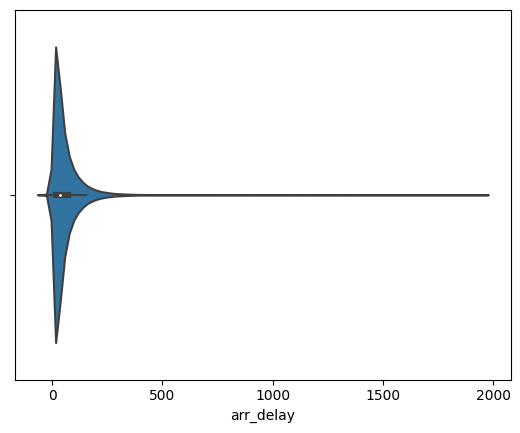

In [30]:
sns.violinplot(data=df_15mins, x ='arr_delay', inner='box', orient='Vertical')

In [28]:
df_15mins.arr_delay.median()

36.0

In [29]:
%%bigquery df_less15mins
select dep_delay, arr_delay
from dsongcp.flights_tzcorr
where dep_delay <= 15

Query is running:   0%|          |

Downloading:   0%|          |

<AxesSubplot:xlabel='arr_delay'>

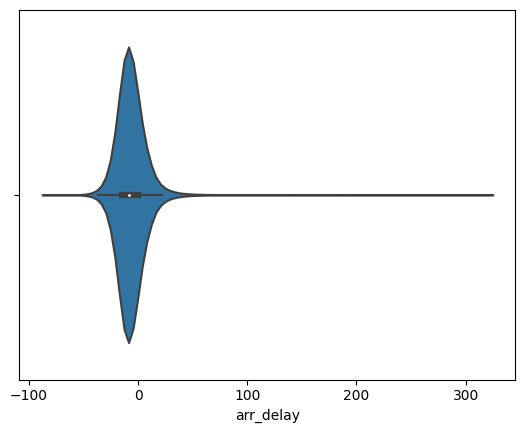

In [31]:
sns.violinplot(data=df_less15mins, x ='arr_delay', inner='box', orient='h')

In [32]:
df_less15mins.arr_delay.median()

-8.0

## Probabilistic Analysis

### Query 1: 
Find average departure and arrival delays at each airport in the US, retain only airports where there were at least 3650 flights, and sort them by departure delay in descending order.

In [37]:
%%bigquery df_us
select avg(dep_delay) as avg_dep_delay, avg(arr_delay) as avg_arr_delay, count(*) as numFlights
from dsongcp.flights_tzcorr
group by origin
having numFlights > 3650
order by avg_dep_delay desc

Query is running:   0%|          |

Downloading:   0%|          |

In [38]:
df_us

,avg_dep_delay,avg_arr_delay,numFlights
0,17.333035,15.261969,7242
1,13.454753,10.576772,6214
2,13.305086,7.596120,627072
3,13.182294,3.922799,222788
4,12.893989,6.768317,188202
...,...,...,...
194,0.752523,-4.617225,3824
195,0.743231,-1.228210,4312
196,0.720691,-2.530503,4896
197,0.588442,-1.058161,22852


### Query 2: 
Assume a flight is delayed if its arrival delay was more than 15 minutes. Find the percentage of the delayed flights.

In [39]:
%%bigquery 
SELECT (COUNT(CASE WHEN arr_delay > 15 THEN 1 END) / COUNT(*)) * 100 AS percentage_delayed
from dsongcp.flights_tzcorr

Query is running:   0%|          |

Downloading:   0%|          |

,percentage_delayed
0,17.58866


### Query 3: We will extract the ORIGINAL records from the database. For exploratory purpose, it is recommeded that only extract a small randomly selected subset for exploration. 
Create a DataFrame containing the ARR_DELAY and DEP_DELAY of 1% of the flights that were departed 15 minutes later than scheduled time. Show the summary statistics of the DataFrame.

In [40]:
%%bigquery df_15
select arr_delay, dep_delay 
from dsongcp.flights_tzcorr
where dep_delay > 15 and rand() < 0.01

Query is running:   0%|          |

Downloading:   0%|          |

In [41]:
df_15.describe()

,arr_delay,dep_delay
count,20364.000000,20511.000000
mean,57.097378,61.672030
std,67.435801,65.594181
min,-44.000000,16.000000
25%,18.000000,24.000000
50%,36.000000,40.000000
75%,73.000000,74.000000
max,1364.000000,1393.000000


## Stop here on 04/25/2023

### Visualization: 
Plot the distribution of the ARR_DELAY of the flights extracted in the DataFrame of Query 3.

<AxesSubplot:xlabel='arr_delay'>

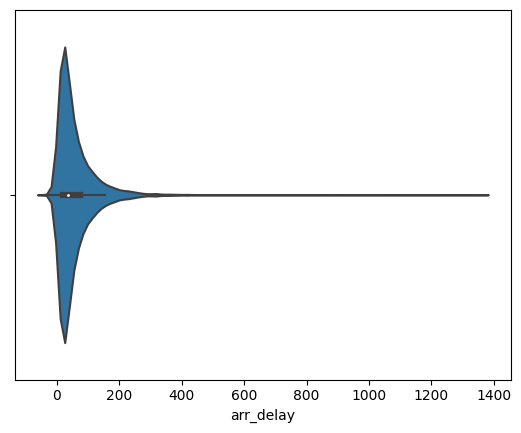

In [42]:
sns.violinplot(data=df_15, x='arr_delay', inner='box')

### Query 4: For exploration, only use a small subset of the original data.
Create a DataFrame containing the ARR_DELAY and DEP_DELAY of 0.1% of all flights. Show the summary statistics of the DataFrame.

In [44]:
# Let us use BigQuery python interface here. 
sql = '''
select arr_delay, dep_delay 
from dsongcp.flights_tzcorr
where rand() < 0.001
'''

from google.cloud import bigquery
bq = bigquery.Client()

df_0001 = bq.query(sql).to_dataframe()

In [45]:
df_0001.describe()

,arr_delay,dep_delay
count,11304.000000,11347.000000
mean,4.695948,9.646955
std,38.862354,36.483757
min,-60.000000,-26.000000
25%,-13.000000,-5.000000
50%,-5.000000,-2.000000
75%,8.000000,7.000000
max,649.000000,655.000000


### Adding Label Column: 
Add a new column 'ontime' to the DataFrame extracted in Query 4 using the following conditions. Show the summary statistics including the 'ontime' column.
-  'ontime' = True if the DEP_DELAY is less than 15 minutes. 
-  Otherwise, 'ontime' = False.

In [46]:
df_0001['ontime'] = df_0001['dep_delay'] < 15

In [49]:
df_0001.head()

,arr_delay,dep_delay,ontime
0,0.0,-3.0,True
1,-12.0,-6.0,True
2,-22.0,-8.0,True
3,10.0,17.0,False
4,1.0,-3.0,True


In [53]:
df_0001.describe(include='all')

,arr_delay,dep_delay,ontime
count,11304.000000,11347.000000,11521
unique,NaN,NaN,2
top,NaN,NaN,True
freq,NaN,NaN,9185
mean,4.695948,9.646955,NaN
std,38.862354,36.483757,NaN
min,-60.000000,-26.000000,NaN
25%,-13.000000,-5.000000,NaN
50%,-5.000000,-2.000000,NaN
75%,8.000000,7.000000,NaN


### Visualization: 
Plot and compare the distributions of ARR_DELAY for flights with 'ontime' = True and flights with 'ontime' = False using the DataFrame above.

<AxesSubplot:xlabel='arr_delay', ylabel='ontime'>

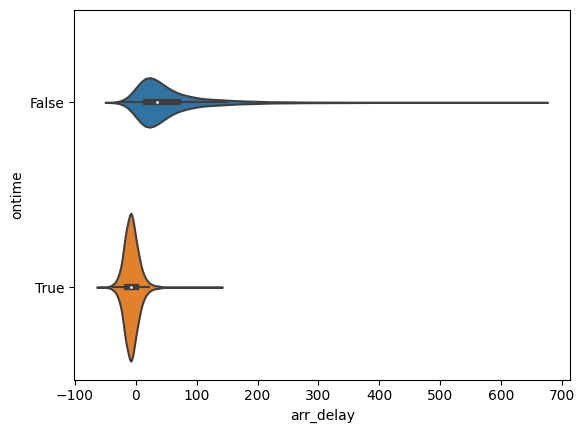

In [61]:
sns.violinplot(data=df_0001, x='arr_delay', y='ontime', inner='box', orient='h')

### Query 5: 
Create a DataFrame containing the average ARR_DELAY and total number of flights for each DEP_DELAY. Order the results by DEP_DELAY in ascending order. Show the head of the DataFrame.

In [62]:
sql = '''
select dep_delay, avg(arr_delay) as avg_arr_delay, count(*) as numFlights
from dsongcp.flights_tzcorr
group by dep_delay
order by dep_delay
'''
df_avg_arr = bq.query(sql).to_dataframe()

In [63]:
df_avg_arr.head()

,dep_delay,avg_arr_delay,numFlights
0,NaN,NaN,172306
1,-82.0,-80.0,2
2,-68.0,-87.0,2
3,-61.0,-77.0,2
4,-56.0,-26.0,2


### Query 6: This time we will filter out the airports that have at least one flight per day, instead of 10 flights per day. We want to include almost all airports in our analysis. Include standard deviations for probabilistic analysis.
Same as above. Create a DataFrame by removing the records with the total number of flights fewer than 365.  Add a column corresponding to the standard deviation of the ARR_DELAY. Show the head of the DataFrame.

In [64]:
# First, retrieve the average arr_delay, standard deviation of arr_delays, num of flights for each dep_delay
sql = '''
select dep_delay, avg(arr_delay) as avg_arr_delay, stddev(arr_delay) as std_arr_delay, count(*) as numFlights
from dsongcp.flights_tzcorr
group by dep_delay
order by dep_delay
'''
df_std = bq.query(sql).to_dataframe()

In [65]:
df_std.shape

(1218, 4)

In [66]:
df_std.head()

,dep_delay,avg_arr_delay,std_arr_delay,numFlights
0,NaN,NaN,NaN,172306
1,-82.0,-80.0,0.0,2
2,-68.0,-87.0,0.0,2
3,-61.0,-77.0,0.0,2
4,-56.0,-26.0,0.0,2


In [68]:
# Second, only select the records that numFlights > 365
df_std = df_std[df_std.numFlights > 365]
df_std.shape

(294, 4)

### Visualization: 
Plot the relations between DEP_DELAYs and its means and standard deviations of ARR_DELAYs using the DataFrame extracted in Query 6.

<AxesSubplot:xlabel='dep_delay'>

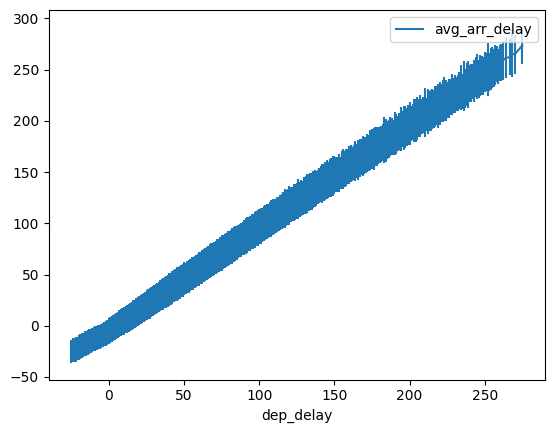

In [69]:
df_std.plot(kind='line', x='dep_delay', y='avg_arr_delay', yerr='std_arr_delay')

### Make Probabilistic Suggestion for Canceling a Meeting at Destination: 
Assume we have an important meeting at destination. We want to decide whether to postpone or cancel the meeting depending on the predicted arrival delay time. Our decision criterion is 15 minutes and 30%. That is, if the plane is more than 30% likely to be delayed (on arrival) by more than 15 minutes, we want to send a text message asking to postpone or cancel the meeting. At what departure delay does this happen? Plot the data to find the DEP_DELAY where there is a 30% chance that the ARR_DELAY is more than 15 minutes using the DataFrame extracted in Query 6.

### Find the records that show avg_arr_delay are around 15 mins

In [75]:
df_std[(df_std.avg_arr_delay > 12) & (df_std.avg_arr_delay < 16)]

,dep_delay,avg_arr_delay,std_arr_delay,numFlights
73,18.0,12.839367,14.204717,64060
74,19.0,13.883165,14.161584,60674
75,20.0,15.002519,14.244092,58188
76,21.0,15.959768,13.963937,53794


### Assume arr_delays follow a normal distribution for a dep_delay. If the mean of the arr_delays is about 15 mins with a std 14 mins, what is the arr_delay at least with 70% probability?

To compute the arrival delay with at least 70% probability, we'll first need to find the Z-score that corresponds to the 70th percentile (or 0.7 cumulative probability) using the inverse cumulative distribution function (also known as the quantile function or percent-point function). Then, we'll use that Z-score, the mean, and the standard deviation to find the corresponding value of arr_delay. 

In [76]:
import scipy.stats as stats
# Find the Z-score for the 70th percentile (0.7 cumulative probability)
z_score = stats.norm.ppf(0.7)
z_score

0.5244005127080407

In [77]:
mean = 15
std = 14

# Calculate the arr_delay value that corresponds to the 70th percentile
arr_delay_70th_percentile = mean + z_score * std

print("The arrival delay with at least 70% probability is approximately:", arr_delay_70th_percentile) 

The arrival delay with at least 70% probability is approximately: 22.34160717791257


### Now, compute the 70% percentiles of the arr_delays for all dep_delays

In [79]:
df_std['arr_delay_70'] = df_std['avg_arr_delay'] + df_std['std_arr_delay'] * z_score

### Plot the 70% percentiles of the arr_delays against the dep_delays

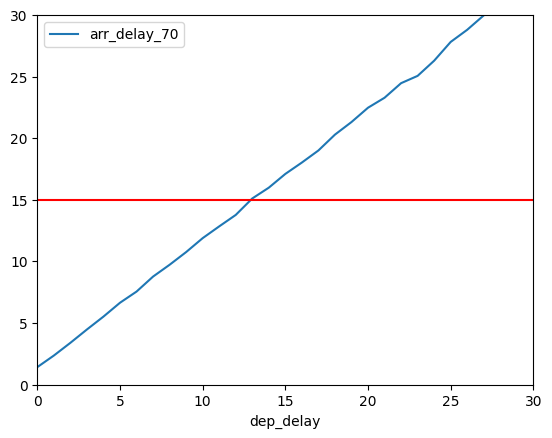

In [83]:
df_std.plot(kind='line', x='dep_delay', y='arr_delay_70', ylim=(0, 30), xlim=(0, 30))
plt.axhline(y=15, color='r')

### Extract the records for decision making:

In [84]:
df_std[(df_std.arr_delay_70 > 12) & (df_std.arr_delay_70 < 16)]

,dep_delay,avg_arr_delay,std_arr_delay,numFlights,arr_delay_70
66,11.0,5.825880,13.378417,100414,12.841529
67,12.0,6.750155,13.387623,94214,13.770631
68,13.0,7.900168,13.742991,87436,15.106999
69,14.0,8.851628,13.600060,82112,15.983507
